In [1]:
import sys
import os
import math

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# 현재 파일이 있는 디렉토리 기준으로 상위 폴더 경로 추가
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # 한 단계 상위 폴더
sys.path.append(parent_dir)

print(f"추가된 경로: {parent_dir}")

from src.tools.google_drive import ensure_data_files

추가된 경로: /Users/levit/study/yamyam-lab


In [2]:
# 현재 파일이 있는 디렉토리 기준으로 상위 폴더 경로 추가
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # 한 단계 상위 폴더
sys.path.append(parent_dir)

print(f"추가된 경로: {parent_dir}")

# Ensure required data files are available
data_paths = ensure_data_files()

추가된 경로: /Users/levit/study/yamyam-lab
기존 data가 존재합니다. 파일 경로를 반환합니다.


In [3]:
# Load data into Pandas DataFrames
print(data_paths)
df_review = pd.read_csv(data_paths["review"], index_col=0)
print(f"데이터 추출: {len(df_review):,}")

{'reviewer': '/Users/levit/study/yamyam-lab/data/reviewer.csv', 'category': '/Users/levit/study/yamyam-lab/data/diner_category_raw.csv', 'review': '/Users/levit/study/yamyam-lab/data/review.csv', 'diner': '/Users/levit/study/yamyam-lab/data/diner.csv'}
데이터 추출: 2,287,474


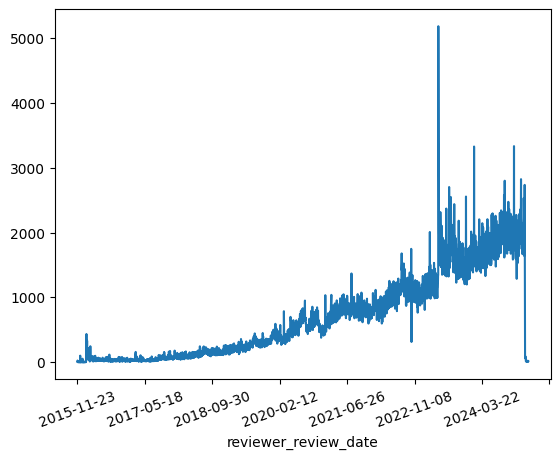

In [4]:
df_review.reviewer_review_date.value_counts().sort_index().plot()
plt.xticks(rotation=20)
plt.show()

In [5]:
df_review.reviewer_review_date.value_counts().sort_index().tail(30)

reviewer_review_date
2025-01-30    1889
2025-01-31    1939
2025-02-01    2734
2025-02-02    1742
2025-02-03     493
2025-02-04      96
2025-02-05      64
2025-02-06      59
2025-02-07      75
2025-02-08      88
2025-02-09      50
2025-02-10      15
2025-02-11      16
2025-02-12      23
2025-02-13      27
2025-02-14      10
2025-02-15      16
2025-02-16      24
2025-02-17      11
2025-02-18      18
2025-02-19      15
2025-02-20      16
2025-02-21      22
2025-02-22      17
2025-02-23      19
2025-02-24      10
2025-02-25      19
2025-02-26      23
2025-02-27      15
2025-02-28      14
Name: count, dtype: int64

In [6]:
ser_to_drop = df_review.reviewer_review_date.str.startswith("2025-02")
print(f"애매해서 드랍: {ser_to_drop.sum()}")
df_review = df_review[~ser_to_drop]

df_review_train = df_review[
    df_review.reviewer_review_date.str.startswith("2024-10") |
    df_review.reviewer_review_date.str.startswith("2024-11") |
    df_review.reviewer_review_date.str.startswith("2024-12")
]
df_review_test = df_review[df_review.reviewer_review_date.str.startswith("2025-01")]
print(f"train: {len(df_review_train):,}")
print(f"test: {len(df_review_test):,}")

애매해서 드랍: 5731
train: 177,414
test: 62,973


In [7]:
df_review_train_agg = df_review_train.groupby(["reviewer_id", "diner_idx"], as_index=False).reviewer_review_score.mean()
user_count = df_review_train_agg.reviewer_id.nunique()
item_count = df_review_train_agg.diner_idx.nunique()
feedback_count = len(df_review_train_agg)
density = feedback_count  / (user_count * item_count)
print(f"유저 수: {user_count:,}")
print(f"식당 수: {item_count:,}")
print(f"피드백 수: {feedback_count:,}")
print(f"Density: {density*100:.4f}%")

유저 수: 93,812
식당 수: 70,246
피드백 수: 177,413
Density: 0.0027%


In [8]:
df_review_test_agg = df_review_test.groupby(["reviewer_id", "diner_idx"], as_index=False).reviewer_review_score.mean()
user_count = df_review_test_agg.reviewer_id.nunique()
item_count = df_review_test_agg.diner_idx.nunique()
feedback_count = len(df_review_test_agg)
density = feedback_count  / (user_count * item_count)
print(f"유저 수: {user_count:,}")
print(f"식당 수: {item_count:,}")
print(f"피드백 수: {feedback_count:,}")
print(f"Density: {density*100:.4f}%")

유저 수: 38,360
식당 수: 34,798
피드백 수: 62,973
Density: 0.0047%


### MP

In [9]:
max_infer_size = df_review_test_agg.groupby("reviewer_id").size().max()

In [10]:
item_mp = df_review_test_agg.diner_idx.value_counts().head(max_infer_size).index

### ALS

In [11]:
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix

In [12]:
# user_cat = df_review_agg["reviewer_id"].astype("category")
# item_cat = df_review_agg["diner_idx"].astype("category")
# rows, cols = user_cat.cat.codes, item_cat.cat.codes
# data = df_review_agg["reviewer_review_score"].values
# mat = coo_matrix((data,(rows,cols))).tocsr()

In [13]:
uid_to_idx = {uid: idx for (idx, uid) in enumerate(df_review_train_agg.reviewer_id.unique().tolist())}
iid_to_idx = {iid: idx for (idx, iid) in enumerate(df_review_train_agg.diner_idx.unique().tolist())}

row, col, dat = df_review_train_agg.reviewer_id.tolist(), df_review_train_agg.diner_idx.tolist(), df_review_train_agg.reviewer_review_score.tolist()
row = [uid_to_idx[r] for r in row]
col = [iid_to_idx[c] for c in col]

train_matrix = csr_matrix((dat, (row,col)), shape=(1 + np.max(row), 1 + np.max(col)))

In [14]:
idx_to_uid = {idx: uid for (uid, idx) in uid_to_idx.items()}
idx_to_iid = {idx: iid for (iid, idx) in iid_to_idx.items()}

In [15]:
from implicit.als import AlternatingLeastSquares

model_imp = AlternatingLeastSquares(factors=50, iterations=30)

model_imp.fit(train_matrix.tocsr())

# user_factors: (num_users, K), item_factors: (num_items, K)
user_factors = model_imp.user_factors
item_factors = model_imp.item_factors

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 30/30 [00:07<00:00,  4.02it/s]


In [16]:
len(user_factors), len(item_factors)

(93812, 70246)

### nDCG

In [17]:
def _ndcg(rec, gt):
    Q, S = 0.0, 0.0
    seen = list(set(gt))
    # rec = recs.get(u, [])
    # if not rec or len(seen) == 0:
    #     continue

    dcg = 0.0
    idcg = sum([1.0 / math.log(i + 2, 2) for i in range(min(len(seen), len(rec)))])
    for i, r in enumerate(rec):
        if r not in seen:
            continue
        rank = i + 1
        dcg += 1.0 / math.log(rank + 1, 2)
    ndcg = dcg / idcg
    S += ndcg
    Q += 1
    return S / Q


In [18]:
# # nDCG@K 계산
# def ndcg_k(y_true, y_pred, k):
#     idx = np.argsort(y_pred)[::-1][:k]
#     y_true_k = np.take(y_true, idx)
#     dcg = np.sum((2**y_true_k - 1) / np.log2(np.arange(2, k + 2)))
#     idcg = np.sum((2**np.sort(y_true)[::-1][:k] - 1) / np.log2(np.arange(2, k + 2)))
#     return dcg / idcg if idcg > 0 else 0

In [19]:
ndcg_score_dict = {}

In [20]:
ndcg_score_list = []
for reviewer_id, group in df_review_test.groupby("reviewer_id"):
    group = group.sort_values(["reviewer_review_score", "reviewer_review_date"], ascending=[False, True])
    ndcg_score = _ndcg(df_review_test_agg.diner_idx.sample(len(group)), group.diner_idx)
    ndcg_score_list.append(ndcg_score)
ndcg_score_dict["random"] = np.mean(ndcg_score_list)

In [21]:
ndcg_score_list = []
for reviewer_id, group in df_review_test.groupby("reviewer_id"):
    group = group.sort_values(["reviewer_review_score", "reviewer_review_date"], ascending=[False, True])
    ndcg_score = _ndcg(item_mp[:len(group)], group.diner_idx)
    ndcg_score_list.append(ndcg_score)
ndcg_score_dict["mp"] = np.mean(ndcg_score_list)

In [22]:
ndcg_score_list = []
cold_count = 0
for reviewer_id, group in tqdm(df_review_test.groupby("reviewer_id")):
    if reviewer_id not in uid_to_idx:
        ndcg_score = _ndcg(item_mp[:len(group)], group.diner_idx)
        cold_count += 1
    else:
        recommendation_result = model_imp.recommend(uid_to_idx[reviewer_id], train_matrix.tocsr()[uid_to_idx[reviewer_id]], len(group))[0]
        iids = [idx_to_iid[iid] for iid in recommendation_result]
        ndcg_score = _ndcg(iids, group.diner_idx)
    ndcg_score_list.append(ndcg_score)
ndcg_score_dict["als"] = np.mean(ndcg_score_list)
print(f"Cold start: {cold_count:,}({cold_count/len(ndcg_score_list)*100:.2f}%)")

100%|██████████| 38360/38360 [00:07<00:00, 5359.27it/s]

Cold start: 26,913(70.16%)


In [23]:
for model, score in ndcg_score_dict.items():
    print(f"{model}: {score:.4f}")

random: 0.0011
mp: 0.0323
als: 0.0272


### 내 추천

In [24]:
df_diner = pd.read_csv("../data/diner.csv")

/var/folders/h0/mpdddzjj3dsgwg0d4_c77ysm0000gn/T/ipykernel_70305/590043976.py:1: DtypeWarning: Columns (5,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_diner = pd.read_csv("../data/diner.csv")


In [25]:
df_review[df_review.reviewer_id == 1210165111]

,diner_idx,reviewer_id,review_id,reviewer_review,reviewer_review_date,reviewer_review_score
1332111,12004662.0,1210165111,6547063,음식은 맛있어요 근데요\n양념갈비 먹은 거에 그대로 오겹살 구워주고 껍데기 구워주고...,2022-11-13,1.0


In [26]:
## 짤라서 없음 ㅜㅜ
# reco_result = model_imp.recommend(uid_to_idx[1210165111], train_matrix.tocsr()[uid_to_idx[1210165111]], 10)[0]
# iids = [idx_to_iid[iid] for iid in reco_result]
# df_diner[df_diner.diner_idx.isin(iids)]

### Item to item 정성평가

In [27]:
df_diner[df_diner.diner_name.str.contains("마노디")]

,diner_idx,diner_name,diner_tag,diner_menu_name,diner_menu_price,diner_review_cnt,diner_review_avg,diner_blog_review_cnt,diner_review_tags,diner_road_address,diner_num_address,diner_phone,diner_lat,diner_lon,diner_open_time,diner_open_time_titles,diner_open_time_hours,diner_open_time_off_days_title,diner_open_time_off_days_hours,bayesian_score
15678,13050974,마노디셰프 명동점,"['제로페이', '모임,회식', '분위기좋은', '소개팅', '데이트']","['봉골레 알리올리오 파스타', '프리미엄 씨푸드 파스타', '흑임자 & 참송이 버...","[19900, 22900, 25900, 27900, 28900, 29900, 319...",56,3.5,4.2,"[""('맛', 17)"", ""('친절', 16)"", ""('분위기', 14)"", ""('...",서울 중구 명동길 26,서울 중구 명동2가 50-14,02-777-7047,37.563446,126.983747,NaN,['영업시간'],"['월~토 11:00 ~ 22:00', '일 11:00 ~ 21:00', '월~금 ...",NaN,[],0.245107
53344,7857136,마노디셰프 강남점,"['모임,회식', '제로페이', '소개팅', '데이트']","['프리미엄 씨푸드 파스타', '감태 페스토 & 씨푸드 보리 리조또', '이탈리안 ...","[8900, 15900, 19900, 21900, 22900, 24900, 2590...",70,2.7,4.3,"[""('맛', 27)"", ""('분위기', 25)"", ""('친절', 21)"", ""('...",서울 강남구 테헤란로 129,서울 강남구 역삼동 648-9,02-553-5311,37.499870,127.032372,NaN,['영업시간'],"['월~토 11:00 ~ 22:00', '일 11:00 ~ 21:00', '월~금 ...",NaN,[],0.227315
60488,1878768223,마노디셰프 잠실점,"['제로페이', '모임,회식', '분위기좋은', '소개팅', '데이트']","['그릴드 치킨 & 시저 샐러드', '프리미엄 머쉬룸 샐러드', '크랩 & 쉬림프 ...","[19900, 21900, 25900, 27900, 28900, 29900, 319...",17,4.0,3.8,"[""('맛', 9)"", ""('친절', 8)"", ""('분위기', 7)"", ""('주차'...",서울 송파구 송파대로 570,서울 송파구 신천동 7-30,02-422-4300,37.515786,127.099115,NaN,['영업시간'],"['월~토 11:00 ~ 22:00', '일 11:00 ~ 21:00', '월~금 ...",NaN,[],0.224660
70834,8969599,마노디셰프 삼성점,"['제로페이', '모임,회식', '분위기좋은', '소개팅', '데이트']","['그릴드 치킨 & 시저 샐러드', '프리미엄 머쉬룸 샐러드', '크랩 & 쉬림프 ...","[8900, 15900, 19900, 21900, 22900, 25900, 2790...",57,3.5,3.8,"[""('맛', 14)"", ""('친절', 9)"", ""('분위기', 7)"", ""('가성...",서울 강남구 테헤란로87길 21,서울 강남구 삼성동 158-9,02-561-9011,37.509052,127.058248,NaN,['영업시간'],"['월~토 11:00 ~ 22:00', '일 11:00 ~ 21:00', '월~금 ...",NaN,[],0.220966


In [28]:
reco_result = model_imp.similar_items(iid_to_idx[7857136])[0]
iids = [idx_to_iid[iid] for iid in reco_result]
df_diner[df_diner.diner_idx.isin(iids)]

,diner_idx,diner_name,diner_tag,diner_menu_name,diner_menu_price,diner_review_cnt,diner_review_avg,diner_blog_review_cnt,diner_review_tags,diner_road_address,diner_num_address,diner_phone,diner_lat,diner_lon,diner_open_time,diner_open_time_titles,diner_open_time_hours,diner_open_time_off_days_title,diner_open_time_off_days_hours,bayesian_score
32326,1079841682,펠리치따,"['카카오페이', '제로페이']",['아메리카노'],[3500],42,4.2,4.8,"[""('맛', 14)"", ""('친절', 10)"", ""('가성비', 8)"", ""('분...",서울 관악구 신림로12길 9,서울 관악구 신림동 119-9,02-885-5775,37.471349,126.938062,NaN,"['영업시간', '공휴일']","['매일 07:00 ~ 21:00', '07:00 ~ 21:00']",NaN,[],0.235047
37826,647726382,또와분식,['제로페이'],"['튀김범벅', '순대범벅', '모듬튀김', '떡볶이', '순대', '야끼만두(3개...","[1500, 2400, 2500, 3000, 3500, 4000, 4500, 650...",11,4.9,4.0,"[""('맛', 4)"", ""('친절', 4)"", ""('가성비', 2)"", ""('분위기...",서울 성동구 마장로35나길 40,서울 성동구 마장동 770-3,02-6052-8083,37.567198,127.043207,NaN,['영업시간'],"['월,화,수,목,토,일 11:00 ~ 21:00', '금 09:30 ~ 22:00']",NaN,[],0.232677
51107,1946162895,꾸브라꼬숯불두마리치킨 포항장량점,['제로페이'],"['치즈스틱', '계바삭', '포장마차 물떡어묵탕', '포장마차 떡볶이', '흑미 ...",NaN,2,3.5,5.0,"[""('맛', 3)"", ""('가성비', 2)"", ""('친절', 2)"", ""('주차'...",경북 포항시 북구 장량로113번길 6,경북 포항시 북구 장성동 1413-3,054-615-9289,36.082545,129.392864,NaN,['영업시간'],['화~일 16:00 ~ 01:30'],['휴무일'],['월요일'],0.228097
53344,7857136,마노디셰프 강남점,"['모임,회식', '제로페이', '소개팅', '데이트']","['프리미엄 씨푸드 파스타', '감태 페스토 & 씨푸드 보리 리조또', '이탈리안 ...","[8900, 15900, 19900, 21900, 22900, 24900, 2590...",70,2.7,4.3,"[""('맛', 27)"", ""('분위기', 25)"", ""('친절', 21)"", ""('...",서울 강남구 테헤란로 129,서울 강남구 역삼동 648-9,02-553-5311,37.499870,127.032372,NaN,['영업시간'],"['월~토 11:00 ~ 22:00', '일 11:00 ~ 21:00', '월~금 ...",NaN,[],0.227315
55516,754503086,수초밥,"['제로페이', '점심식사']","['수초밥', '연어초밥']","[14000, 19000]",4,4.3,4.8,"[""('맛', 4)"", ""('가성비', 4)"", ""('친절', 4)""]",서울 강서구 마곡중앙5로 87,서울 강서구 마곡동 739-2,02-2664-7072,37.567260,126.817553,NaN,"['영업시간', '공휴일']","['월,수,목,금 11:30 ~ 21:00', '토,일 12:00 ~ 21:00',...",['휴무일'],"['화요일, 1월1일']",0.226487
69788,1088235175,멘소레,"['제로페이', '혼밥']","['부타동', '타코라이스', '새우튀김 하이라이스', '사시미덮밥', '치킨데리야...","[10900, 12900, 13900, 18900, 20000]",3,4.8,3.7,"[""('맛', 3)""]",서울 종로구 새문안로 92,서울 종로구 신문로1가 163,NaN,37.569699,126.974908,NaN,['영업시간'],"['월~금 11:00 ~ 20:00', '월~금 라스트오더 ~ 19:30', '월~...",['휴무일\n휴무일\n수정 제안\n이동하기'],"['토,일요일, 더보기']",0.221389
70456,2058969513,동양식당 마곡점,"['점심식사', '제로페이', '데이트', '혼밥']","['와사비 비빔국수', '바질 비빔국수', '동양 짬뽕', '동양 짬뽕밥', '동양...","[8500, 9000, 9500, 10000, 11000, 14000]",37,4.8,3.8,"[""('맛', 15)"", ""('가성비', 8)"", ""('친절', 6)"", ""('분위...",서울 강서구 마곡중앙5로1길 20,서울 강서구 마곡동 365-15,02-2093-6633,37.568665,126.826710,NaN,['금일영업마감'],['매일 11:00 ~ 21:00'],NaN,[],0.221115
77363,1759641921,이태리포차,['제로페이'],"['할라피뇨파스타', '감바스알아히요', '후라이드치킨', '알리오올리오', '버섯...","[7000, 8000, 9000, 15000, 17000]",25,5.0,4.8,"[""('가성비', 11)"", ""('맛', 8)"", ""('친절', 7)"", ""('분위...",서울 강서구 양천로30길 32,서울 강서구 마곡동 326-19,NaN,37.571797,126.822611,NaN,['영업시간'],"['월~토 11:30 ~ 23:00', '월~토 라스트오더 ~ 22:00', '월~...",['휴무일'],"['둘째,넷째, 월요일, 일요일']",0.218681
86044,655089776,6842고기밥상,"['카카오페이', '제로페이']","['참숯돼지불고기+계절된장+가마솥밥', '매콤제육볶음+계절된장+가마솥밥', '한우육...","[9000, 12000, 15000, 28000]",9,4.3,1.8,"[""('맛', 2)"", ""('가성비', 2)"", ""('친절', 2)"", ""('분위기...",서울 종로구 인사동길 30-14,서울 종로구 관훈동 2-3,NaN,126.986276,37.573689,NaN,['영업중'],['매일 11:30 ~ 21:00'],NaN,[],0.215346
119846,1220846916,쿠차라 SFC점,"['카카오페이', '멕시코요리', '혼밥']","['스테이크', '그릴치킨', '그릴새우', '치킨', '까르니따스']","[8900, 9900, 12900, 13900]",36,2.6,3.8,"[""('맛', 7)"", ""('분위기', 5)"", ""('가성비', 2)""]",서울 중구 세종대로 136,서울 중구 무교동 97,02-6949-3155,37.568422,126.978258,NaN,"['영업시간', '공휴일']","['월~금 11:00 ~ 21:00', '토,일 11:00 ~ 19:00', '11...",NaN,[],0.189850


In [29]:
df_diner[df_diner.diner_name.str.contains("옷살")]

,diner_idx,diner_name,diner_tag,diner_menu_name,diner_menu_price,diner_review_cnt,diner_review_avg,diner_blog_review_cnt,diner_review_tags,diner_road_address,diner_num_address,diner_phone,diner_lat,diner_lon,diner_open_time,diner_open_time_titles,diner_open_time_hours,diner_open_time_off_days_title,diner_open_time_off_days_hours,bayesian_score
5316,12740961,옷살 서울대입구본점,"['모임,회식']","['버터 마살라 Butter Masala', '티카 마살라 Tikka Masala'...",NaN,202,3.8,4.4,"['맛', '59', '친절', '41', '분위기', '37', '가성비', '1...",서울 관악구 관악로 164,서울 관악구 봉천동 856-5,02-882-6527,37.479764,126.952999,NaN,['영업시간'],['매일 11:00 ~ 22:00'],NaN,[],0.259565
128773,1259810362,옷살 철산점,"['인도카레', '모임,회식', '인도요리', '인도음식', '철산맛집']","['Lachha Paratha 라차파라타', 'Biryani Rice 비리야니 라이...","[3900, 4900, 7900, 9900, 11900]",3,4.5,4.7,"[""('맛', 3)"", ""('가성비', 3)"", ""('친절', 3)"", ""('분위기...",경기 광명시 철산로30번길 5,경기 광명시 철산동 395,02-875-6527,37.475857,126.869949,NaN,['영업시간'],"['매일 11:00 ~ 22:00', '매일 휴게시간 15:00 ~ 17:00']",NaN,[],0.000000


In [30]:
reco_result = model_imp.similar_items(iid_to_idx[12740961])[0]
iids = [idx_to_iid[iid] for iid in reco_result]
df_diner[df_diner.diner_idx.isin(iids)]

,diner_idx,diner_name,diner_tag,diner_menu_name,diner_menu_price,diner_review_cnt,diner_review_avg,diner_blog_review_cnt,diner_review_tags,diner_road_address,diner_num_address,diner_phone,diner_lat,diner_lon,diner_open_time,diner_open_time_titles,diner_open_time_hours,diner_open_time_off_days_title,diner_open_time_off_days_hours,bayesian_score
5316,12740961,옷살 서울대입구본점,"['모임,회식']","['버터 마살라 Butter Masala', '티카 마살라 Tikka Masala'...",NaN,202,3.8,4.4,"['맛', '59', '친절', '41', '분위기', '37', '가성비', '1...",서울 관악구 관악로 164,서울 관악구 봉천동 856-5,02-882-6527,37.479764,126.952999,NaN,['영업시간'],['매일 11:00 ~ 22:00'],NaN,[],0.259565
11108,601097897,샹츠마라 숭실대점,['혼밥'],"['샹츠마라팅', '미리샹궈', '미니꿔바로우', '볶은밥', '꽃빵 (5p)']","[5000, 6900, 7000, 9000, 16000]",10,4.2,3.5,"[""('맛', 6)"", ""('가성비', 5)"", ""('친절', 4)"", ""('분위기...",서울 동작구 사당로 20,서울 동작구 상도동 505-6,02-822-1888,37.495175,126.956673,NaN,['영업시간'],"['매일 10:30 ~ 22:30', '매일 라스트오더 ~ 22:00']",NaN,[],0.249678
11409,1561846903,로우베어,['핸드드립'],"['브루잉커피(ice, hot)', '바닐라 라떼(ice, hot)', '코스타리카...","[4000, 4500, 5000, 5500, 6000, 7500]",12,4.6,4.2,"[""('친절', 9)"", ""('맛', 8)"", ""('가성비', 4)"", ""('분위기...",서울 노원구 동일로186길 76,서울 노원구 공릉동 506-29,0507-104-8577,37.625369,127.077169,NaN,['영업전'],['매일 10:00 ~ 22:00'],NaN,[],0.249312
21061,1372738122,정짓간,"['신평동막국수', '미슐랭 빕그루망', '안심식당', '노포', '제로페이', '...","['돼지국밥', '순대국밥', '내장국밥', '섞어국밥', '만디국밥', '수육백반...","[1000, 2000, 4900, 5500, 8000, 9000, 9500, 100...",24,4.3,4.3,"[""('맛', 14)"", ""('주차', 14)"", ""('가성비', 9)"", ""('친...",부산 사하구 비봉로 6,NaN,0507-1381-2901,35.095685,128.962485,NaN,['영업시간'],"['월,수,목,금,토,일 00:00 ~ 24:00', '화 06:00 ~ 23:55']",['휴무일'],"['설당일, 추석당일']",0.240871
24142,1495324947,철판집,"['이동약자접근', '철판요리', '제로페이', '합정핫플', '이벤트', '합정맛...","['스테이크 세트', '랍스터 세트', '해물 세트', '오코노미야끼', '해물 볶...","[14000, 16000, 17000, 28000, 34000, 36000]",38,4.5,4.1,"[""('맛', 11)"", ""('친절', 10)"", ""('분위기', 10)"", ""('...",서울 마포구 독막로3길 24-11,서울 마포구 서교동 396-21,02-6084-9233,37.549158,126.917558,NaN,['영업시간'],"['월~목 17:00 ~ 01:00', '금 17:00 ~ 02:00', '토 16...",NaN,[],0.239069
46535,1861565775,오스틴타코 낙성대본점,"['비스트로', '멕시코요리', '데이트', '혼밥', '이국적인']","['2인비프비리아세트', '2인비리아세트', '2인화이타세트', '비리아타코', '...",NaN,19,2.5,3.6,"[""('맛', 7)"", ""('가성비', 6)"", ""('친절', 4)"", ""('분위기...",서울 관악구 봉천로 566-1,서울 관악구 봉천동 1628,0503-7151-2917,37.477408,126.960380,NaN,['영업시간'],"['월,수,목,금,토,일 11:30 ~ 22:00', '월,수,목,금,토,일 휴게시...",['휴무일'],['화요일'],0.229798
68449,1722716342,가치,"['이동약자접근', '위스키바', '혼술', '칵테일바', '분위기좋은', '소개팅']","['칵테일', '위스키 및 전통주']",NaN,6,4.4,4.8,"[""('맛', 6)"", ""('친절', 6)"", ""('분위기', 6)"", ""('가성비...",서울 마포구 새창로6길 18,서울 마포구 도화동 184-10,02-6351-9789,37.541278,126.952652,NaN,['영업시간'],['월~토 18:00 ~ 02:00'],['휴무일\n휴무일\n수정 제안\n이동하기'],"['일요일, 더보기']",0.221801
69002,10875602,피자스쿨 낙성대역점,"['카카오페이', '피맥', '제로페이']","['고구마피자', '까르보네피자', '깐쇼새우피자', '나폴리피자', '닭안심살피자...","[6900, 8900, 9900, 10900, 11900, 12900, 13900,...",21,4.6,4.0,"[""('가성비', 6)"", ""('맛', 5)"", ""('친절', 4)""]",서울 관악구 남부순환로 1949,서울 관악구 봉천동 1688-128,02-875-7771,37.476533,126.965556,NaN,['영업시간'],"['목~토 11:00 ~ 23:20', '수,일 11:00 ~ 23:00', '월 ...",NaN,[],0.221678
106711,1329609210,장어사랑,['점심식사'],"['장어소금구이(손질후 250g)', '활전복구이(4마리)', '활전복구이(8마리)...","[5000, 7000, 16000, 25000, 32000, 37000]",25,4.0,4.0,"['맛', '16', '주차', '16', '친절', '15', '분위기', '8'...",경기 성남시 수정구 설개로 8,경기 성남시 수정구 시흥동 85-1,031-756-9001,37.421420,127.105348,NaN,[],[],NaN,[],0.205435
171710,1960129052,카페 프로우스트,[],[],NaN,1,4.5,5.0,"[""('맛', 2)"", ""('가성비', 2)""]",서울 강동구 올림픽로 675,서울 강동구 천호동 354-6,NaN,37.541819,127.124230,NaN,[],[],NaN,[],0.000000


In [31]:
df_diner[df_diner.diner_name.str.contains("플록")]

,diner_idx,diner_name,diner_tag,diner_menu_name,diner_menu_price,diner_review_cnt,diner_review_avg,diner_blog_review_cnt,diner_review_tags,diner_road_address,diner_num_address,diner_phone,diner_lat,diner_lon,diner_open_time,diner_open_time_titles,diner_open_time_hours,diner_open_time_off_days_title,diner_open_time_off_days_hours,bayesian_score
86139,1636342582,플록,"['양식', '프렌치', '프랑스음식', '제로페이', '모임,회식', '맛집', ...",['어니언스프'],[15000],33,3.4,4.6,"[""('맛', 16)"", ""('친절', 14)"", ""('분위기', 13)"", ""('...",서울 광진구 자양로19길 8,서울 광진구 자양동 769-12,0507-1467-7701,37.539263,127.082712,NaN,['영업시간'],"['금~일 11:30 ~ 22:00', '수,목 17:30 ~ 22:00', '금~...",['휴무일'],"['월,화요일, 설당일, 설다음날, 추석당일, 추석다음날']",0.215298
137475,1257542179,플록스,[],[],NaN,0,4.5,0.0,"[""('', None)""]",서울 성동구 성덕정길 92-2,서울 성동구 성수동2가 532-37,NaN,37.537608,127.053748,NaN,[],[],NaN,[],0.000000


In [32]:
reco_result = model_imp.similar_items(iid_to_idx[1636342582])[0]
iids = [idx_to_iid[iid] for iid in reco_result]
df_diner[df_diner.diner_idx.isin(iids)]

,diner_idx,diner_name,diner_tag,diner_menu_name,diner_menu_price,diner_review_cnt,diner_review_avg,diner_blog_review_cnt,diner_review_tags,diner_road_address,diner_num_address,diner_phone,diner_lat,diner_lon,diner_open_time,diner_open_time_titles,diner_open_time_hours,diner_open_time_off_days_title,diner_open_time_off_days_hours,bayesian_score
600,352472661,양식문화,"['양갈비', '양식문화', '코스요리', '제로페이', '프렌치랙', '양고기',...","['양식문화 코스', '프렌치랙 (170~200g)', '양갈비(220~250g)'...","[5000, 8000, 20000, 25000, 33000, 35000, 43000]",27,4.5,4.7,"[""('맛', 19)"", ""('분위기', 16)"", ""('가성비', 14)"", ""(...",서울 용산구 한강대로76길 11-4,서울 용산구 남영동 101-4,02-6448-7751,37.541769,126.973905,NaN,"['영업시간', '공휴일']","['월~금 17:00 ~ 23:00', '토,일 16:00 ~ 23:00', '16...",NaN,[],0.291510
9653,1501525664,술비,"['혜화술집', '대학로술집', '혜화맛집', '혜화연극', '대학로맛집']","['바지락버터 술찜과 파스타', '살치살 구이와 메쉬 포테이토', '청양 쉬림프 파...","[9000, 12000, 14000, 19000, 22000, 24000, 2800...",27,3.2,4.4,"[""('맛', 18)"", ""('친절', 16)"", ""('분위기', 15)"", ""('...",서울 종로구 대학로14길 17,서울 종로구 혜화동 163-33,02-6487-4141,37.584130,127.002477,NaN,"['영업시간', '공휴일']","['월~금 17:00 ~ 01:00', '토,일 16:00 ~ 01:00', '16...",NaN,[],0.251547
13875,1981241885,장홍김밥,"['카카오페이', '제로페이']","['장홍김밥', '명란김밥', '김밥', '홍김밥', '홍게라면', '오징어튀김',...",NaN,64,3.4,4.0,"[""('맛', 29)"", ""('친절', 15)"", ""('가성비', 6)"", ""('분...",강원특별자치도 속초시 중앙로147번길 16,강원특별자치도 속초시 중앙동 471-4,0507-1371-0357,38.204276,128.590424,NaN,['영업시간'],"['매일 12:00 ~ 19:00', '매일 라스트오더 ~ 18:30']",NaN,[],0.246747
19465,461883111,환이네갈비살 본점,['제로페이'],"['소갈비살(120g)', '차돌박이(120g)', '생삼겹살(170g)', '한우...","[4000, 12000, 14000, 20000]",31,4.6,4.0,"[""('맛', 13)"", ""('친절', 8)"", ""('가성비', 7)"", ""('분위...",서울 광진구 아차산로29길 24,서울 광진구 화양동 9-36,02-466-9287,37.541912,127.068671,NaN,"['영업시간', '공휴일']","['매일 11:30 ~ 23:30', '11:30 ~ 23:30']",['휴무일'],"['설전날, 설당일, 설다음날']",0.242023
58638,949364137,디도재즈라운지,"['분위기좋은', '빈티지분위기', '제로페이', '혼술', '라운지펍', '재즈바...","['곶감 치즈 플레이트', '들기름 낙지젓 카페리니 파스타', '청양 오일 크림 파...","[15000, 18000, 20000, 35000]",53,3.3,4.3,"[""('분위기', 19)"", ""('맛', 8)"", ""('친절', 8)"", ""('가성...",서울 광진구 자양로18길 56,서울 광진구 구의동 243-6,NaN,37.537863,127.086634,NaN,['영업시간'],"['화~금 18:30 ~ 24:00', '토,일 15:00 ~ 24:00']",['휴무일'],['월요일'],0.225353
86139,1636342582,플록,"['양식', '프렌치', '프랑스음식', '제로페이', '모임,회식', '맛집', ...",['어니언스프'],[15000],33,3.4,4.6,"[""('맛', 16)"", ""('친절', 14)"", ""('분위기', 13)"", ""('...",서울 광진구 자양로19길 8,서울 광진구 자양동 769-12,0507-1467-7701,37.539263,127.082712,NaN,['영업시간'],"['금~일 11:30 ~ 22:00', '수,목 17:30 ~ 22:00', '금~...",['휴무일'],"['월,화요일, 설당일, 설다음날, 추석당일, 추석다음날']",0.215298
113432,124338573,모터시티 이태원점,['이태원 이태원피자 피맥 피자펍 이국적인 제로페이'],"['JACKSON 5', 'CHEESE PIZZA', 'PEPPERONI', 'MO...","[21000, 22900, 24900, 26900]",144,4.4,3.7,"['맛', '36', '분위기', '18', '친절', '11', '가성비', '4']",서울 용산구 이태원로 140-1,서울 용산구 이태원동 56-30,02-794-8877,37.533966,126.989433,NaN,['영업시간'],"['월~토 11:30 ~ 22:30', '일 11:30 ~ 22:00']",NaN,[],0.198895
115811,2138825234,성북동이안,"['데이트', '비스트로', '소개팅', '제로페이']","['이베리코스테이크', '루꼴라브루스케타', '모둠 브루스케타', '구운 버섯 샐러...",NaN,45,4.1,4.5,"[""('맛', 13)"", ""('분위기', 11)"", ""('가성비', 6)"", ""('...",서울 성북구 성북로5길 29-19,서울 성북구 성북동1가 105-11,02-744-2919,37.588953,127.002899,월~목 17:00 ~ 22:00,NaN,NaN,NaN,NaN,0.196112
125602,598352945,달콤한위로,"['빈티지분위기', '제로페이', '디저트카페', '루프탑있는']","['프랑스마카롱', '파리브레스트', '프랑스크림도넛', '크렘브륄레', '퐁당 오...","[2800, 3000, 3500, 3800, 4500, 5000, 6000, 650...",50,4.5,3.7,"[""('맛', 10)"", ""('분위기', 6)"", ""('친절', 5)"", ""('주차...",서울 성북구 창경궁로43길 24,서울 성북구 성북동1가 47,02-766-1236,37.589036,127.004189,NaN,['영업전'],['매일 11:00 ~ 21:00'],NaN,[],0.172055
229989,379525132,미수국밥 신당점,NaN,NaN,NaN,5,5.0,3.5,"[""('맛', 5)"", ""('가성비', 2)"", ""('친절', 1)""]",서울 중구 다산로42길 80,서울 중구 신당동 155-1,NaN,37.564718,127.023593,매일 00:00 ~ 24:00,NaN,NaN,NaN,NaN,0.000000


In [33]:
## 상위 점유
df_review.diner_idx.value_counts(normalize=True).sort_values(ascending=False).cumsum().head(30)

diner_idx
1.580890e+09    0.002013
1.851468e+07    0.002848
1.465970e+09    0.003652
1.033241e+07    0.004406
1.287092e+09    0.005150
2.320562e+08    0.005881
2.808218e+07    0.006589
8.563477e+08    0.007194
1.154752e+07    0.007798
2.687188e+07    0.008397
1.567103e+09    0.008995
1.021253e+09    0.009577
1.497730e+09    0.010157
2.682358e+08    0.010726
8.025375e+06    0.011270
4.714084e+08    0.011792
2.724473e+07    0.012279
2.549189e+08    0.012761
2.367242e+08    0.013238
2.008938e+07    0.013707
2.155510e+07    0.014169
5.523691e+08    0.014619
7.846414e+06    0.015067
1.985225e+09    0.015503
2.077290e+09    0.015936
1.424087e+09    0.016355
2.055716e+07    0.016773
1.780979e+07    0.017188
2.660258e+07    0.017598
9.595293e+08    0.017991
Name: proportion, dtype: float64

In [34]:
"""
dot product 테스트 중
## sim item
item_factors[iid_to_idx[565712525]] @ item_factors[iid_to_idx[1636342582]]

## 유사도 1위
item_factors[iid_to_idx[1308794469]] @ item_factors[iid_to_idx[1636342582]]

item_factors[iid_to_idx[1636342582]] @ item_factors.T

df_diner[df_diner.diner_idx.isin([idx_to_iid[13]])]

dot_prod = item_factors[iid_to_idx[1636342582]] @ item_factors.T
reco_result = [idx_to_iid[i] for i in np.argsort(dot_prod)[-10:]]
df_diner[df_diner.diner_idx.isin(reco_result)]
"""

'\ndot product 테스트 중\n## sim item\nitem_factors[iid_to_idx[565712525]] @ item_factors[iid_to_idx[1636342582]]\n\n## 유사도 1위\nitem_factors[iid_to_idx[1308794469]] @ item_factors[iid_to_idx[1636342582]]\n\nitem_factors[iid_to_idx[1636342582]] @ item_factors.T\n\ndf_diner[df_diner.diner_idx.isin([idx_to_iid[13]])]\n\ndot_prod = item_factors[iid_to_idx[1636342582]] @ item_factors.T\nreco_result = [idx_to_iid[i] for i in np.argsort(dot_prod)[-10:]]\ndf_diner[df_diner.diner_idx.isin(reco_result)]\n'